# Variational Quantum Linear Solver

This demo shows how to apply the Variational Quantum Eigen-Solver (VQE) method to solve the following linear equation $ A x = b $:

$$
\begin{array}{ll}
\begin{bmatrix}
   2 &  5 & -13 \\
   3 & -9 &   3 \\
  -5 &  6 &   8 \\
\end{bmatrix} \begin{bmatrix}
  12 \\
  5 \\
  3 \\
\end{bmatrix} = \begin{bmatrix}
  10 \\
  0 \\
  -6 \\
\end{bmatrix}
\end{array}
$$

Note that compared with the original problem, we've divided by 100 at both side. This is harmless since they are equivalent.

### Step 1: Pre-process

First, quantum circuits are capable to handle matrix whose dimension is power of 2. Let's expand the equation from 3x3 to 4x4!  
To be specific, we add a constant **1** to right-bottom corner of $ A $, $ x $ and $ b $, calling it **scaling indicator** as we'll use it to decode the de-normalized solution from a normalized quantum state later.  

$$
\begin{array}{ll}
\begin{bmatrix}
   2 &  5 & -13 & 0 \\
   3 & -9 &   3 & 0 \\
  -5 &  6 &   8 & 0 \\
   0 &  0 &   0 & 1 \\
\end{bmatrix} \begin{bmatrix}
  12 \\
  5 \\
  3 \\
  1 \\
\end{bmatrix} = \begin{bmatrix}
  10 \\
  0 \\
  -6 \\
  1 \\
\end{bmatrix}
\end{array}
$$

Second, following the VQE procedure, the right-hand vector b is required to be a valid quantum state $ \left| b \right> $, hence we divide both side by $ ||b|| $ to make it a unit vector, turning this equation into $ \tilde A \tilde x = \tilde b $:

$$
\begin{array}{ll}
\begin{bmatrix}
   0.1709 &  0.4272 & -1.1107 & 0.     \\
   0.2563 & -0.7689 &  0.2563 & 0.     \\
  -0.4272 &  0.5126 &  0.6835 & 0.     \\
   0.     &  0.     &  0.     & 0.0854 \\
\end{bmatrix} \begin{bmatrix}
  12 \\
  5 \\
  3 \\
  1 \\
\end{bmatrix} = \begin{bmatrix}
  0.8544 \\
  0.     \\
 -0.5126 \\
  0.0854 \\
\end{bmatrix}
\end{array}
$$

In [1]:
from typing import Tuple
import numpy as np
from numpy import ndarray

def print_matrix(A:ndarray, name:str='A'):
  print(f'{name}: (norm={np.linalg.norm(A):.4g}, shape={A.shape})')
  print(A.round(4))

def preprocess() -> Tuple[ndarray, ndarray]:
  # MAGIC: we add a scaling indicator 1 at the right-bottom of the expanded space
  # it tells us how to rescale the normalized quantum solution back to real :)
  Am_ex = np.asarray([
    [ 2,  5, -13, 0],
    [ 3, -9,   3, 0],
    [-5,  6,   8, 0],
    [ 0,  0,   0, 1],
  ])
  bv_ex = np.asarray([[10, 0, -6, 1]]).T
  # normalize
  A = Am_ex / np.linalg.norm(bv_ex)
  b = bv_ex / np.linalg.norm(bv_ex)   # |b>
  return A, b

A, b = preprocess()
print('[Equation (preprocessed)]')
print_matrix(A, 'A')
print_matrix(b, '|b>')

[Equation (preprocessed)]
A: (norm=1.757, shape=(4, 4))
[[ 0.1709  0.4272 -1.1107  0.    ]
 [ 0.2563 -0.7689  0.2563  0.    ]
 [-0.4272  0.5126  0.6835  0.    ]
 [ 0.      0.      0.      0.0854]]
|b>: (norm=1, shape=(4, 1))
[[ 0.8544]
 [ 0.    ]
 [-0.5126]
 [ 0.0854]]


### Step 2: VQE procedure

To briefly explain VQE, one need to design a **Hamiltonian** H and a parametrized **ansatz** $ U(\theta) $, then minimize the hamiltonian expection $ E = \left< x | H | x \right> $ by **optimizing** with parameters $ \theta $.  
When $ E $ reaches the minimal, the ansatz-state $ \left| x \right> = U(\theta) \left| 0 \right> $ will become the ground-state of H, and the expectation value will be the ground-state energy.

⚪ Hamiltonian design

Following essay [arXiv:1909.03898](https://arxiv.org/abs/1909.03898), we define the Hamiltonian $ H_A = A^\dagger (I - \left| b \right> \left< b \right|) A $, and one can easily verify that the normalized quantum state $ \left| \hat x \right> = \frac{\tilde x}{||\tilde x||} $ is right the ground-state of $ H_A $ with energy 0.

In [2]:
n_qubits = int(np.ceil(np.log2(A.shape[0])))
H_A = A.conj().T @ (np.eye(2**n_qubits) - b @ b.conj().T) @ A    # Eq. 6
print('[Hamiltonian]')
print_matrix(H_A, 'H_A')

[Hamiltonian]
H_A: (norm=1.203, shape=(4, 4))
[[ 1.4420e-01 -3.8040e-01  5.8100e-02 -2.7000e-03]
 [-3.8040e-01  1.0261e+00 -1.8840e-01 -7.0000e-04]
 [ 5.8100e-02 -1.8840e-01  7.8300e-02  9.5000e-03]
 [-2.7000e-03 -7.0000e-04  9.5000e-03  7.2000e-03]]


⚪ Ansatz design

Then we're to design a parametrized ansatz to prepare this state $ \left| \hat x \right> $.  
We found this circuit below consisting of 3 RY gates and 1 CNOT gate will just do it, and it only has 3 trainable parameters in the RY gates.  

[Ansatz]


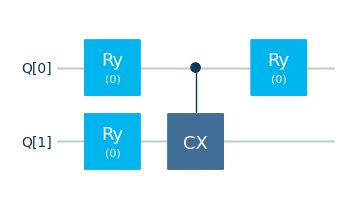

In [3]:
from spinqit import Circuit, Ry, CNOT
from spinqit.view import draw
from spinqit import get_compiler

print('[Ansatz]')
circ = Circuit()
qv = circ.allocateQubits(n_qubits)
circ << (Ry, qv[0], 0)
circ << (Ry, qv[1], 0)
circ << (CNOT, [qv[0], qv[1]])
circ << (Ry, qv[0], 0)
compiler = get_compiler('native')
ir = compiler.compile(circ, level=0)
draw(ir)

⚪ Parameter optimizing

We implemented this part using both PennyLane and SpinQit, please refer to [run_VALA.py](./run_VALA.py) and [run_VALA_spinqit.py](./run_VALA_spinqit.py), respectively.  
NOTE: the PennyLane implementation has slight better numerical accuracy than the SpinQit one, we'd prefer it.

The optimizer configs are: SGD with momentum, n_iter=3000, lr=1.5  
We zero-initialize all the parameters, and finally got [-0.047208991809220814, 0.7808882554867012, 0.509390326201012] after training.  

![run](./img/run_VALA.png)

### Step 3: Run the pretrained circuit

Once the trainable parameters are well-optimized, we can run the circuit to obtain the ansatz-state, which corresponds to the ground-state of the Hamiltonian, and also corresponds to the solution of our expanded equation.  
What we care about most is the `state`, i.e. the quantum state amplitude. It should be real vector that encodes the normalized solution $ \left| \hat x \right> = \frac{\tilde x}{||\tilde x||} $ corresponding to the original algebraic solution $ x $.

In [4]:
from spinqit import get_basic_simulator, get_compiler, BasicSimulatorConfig

shots = 100000

compiler = get_compiler('qasm')
exe = compiler.compile('log/run_VALA.qasm', level=0)    # load pretrained params
engine = get_basic_simulator()
config = BasicSimulatorConfig()
config.configure_shots(shots)
result = engine.execute(exe, config)

keys = ['00', '01', '10', '11']
state = [it.real for it in result.states]
probs = [result.probabilities.get(key, 0.0) for key in keys]
print('[Theoretical Results]')
print('state:', state)
print('probs:', probs)
counts = [result.counts.get(key, 0) for key in keys]
freqs = [result.counts.get(key, 0) / shots for key in keys]
print('[Practical Results]')
print('counts:', counts)
print('freqs:', freqs)

[Theoretical Results]
state: [0.8969221113267619, 0.37371754633444176, 0.22423052780399913, 0.07474350925430306]
probs: [0.8044692737868563, 0.13966480443823562, 0.05027932959926003, 0.005586592175648088]
[Practical Results]
counts: [80447, 13966, 5028, 559]
freqs: [0.80447, 0.13966, 0.05028, 0.00559]


### Step 4: Post-process

In order to decode the desired solution $ x $ from the measured quantum results $ \left| \hat x \right> $ above, we need some additional classical operations.  
Firstly, we define several utility functions, and set up the ground truth for precision evaluations. Then we discuss of both simulator and real-chip situations.  

In [5]:
import numpy as np
from numpy import ndarray

def state_norm(psi:ndarray) -> ndarray:
  return psi / np.linalg.norm(psi)

def get_fidelity(psi:ndarray, phi:ndarray) -> float:
  return np.abs(np.dot(psi.conj().T, phi)).item()

def get_L1_error(x:ndarray, y:ndarray) -> float:
  return np.abs(x - y).mean().item()

def postprocess(x_tilde:ndarray) -> ndarray:
  global x_gt
  x_hat = x_tilde / x_tilde[-1].item()
  x_hat = x_hat[:len(x_gt)]
  return x_hat

# The algebraic target solution
x_gt = np.asarray([12, 5, 3])
# The quantum target solution, corresponding to the ansatz-state
x_state_gt = state_norm(np.asarray([12, 5, 3, 1]))

print('The algebraic solution truth:', x_gt)
print('The quantum solution truth:', x_state_gt)

The algebraic solution truth: [12  5  3]
The quantum solution truth: [0.89692211 0.37371755 0.22423053 0.07474351]


⚪ Simulator

For simulators, we can access `state` and `probs`, and recover a very ideal solution :)  
As shown below, the fidelity just reaches perfect `1.0` at the quantum side, and the L1 error is less than `1e-8` at the decoded algebraic side.  

In [6]:
print('The quantum solution:', state)
print('>> fidelity:', get_fidelity(np.asarray(state), x_state_gt))

x_hat_s = postprocess(np.asarray(state))
print('The decoded algebraic solution:', x_hat_s)
print('>> L1 error:', get_L1_error(x_hat_s, x_gt))

The quantum solution: [0.8969221113267619, 0.37371754633444176, 0.22423052780399913, 0.07474350925430306]
>> fidelity: 1.0
The decoded algebraic solution: [12.  5.  3.]
>> L1 error: 1.6908560477683447e-09


⚪ Real-Chip

For real-hardware devices, we can only access `counts` and `freqs`, hence get an approximated solution :(  
Here we use `shots=1e5`, hence the theoretical precision of `fidelity` will be about `1e-8`, though in practice it reaches a better `1e-9` here.  
And the decoded solution shows a magnitude of `1e-3` in L1 error, just acceptible.  

In [7]:
# approximate the state amplitudes from Q-measured frequency, up to a sign (±)
state_approx = np.sqrt(freqs)
print('The quantum solution (approx):', state_approx)
print('>> fidelity:', get_fidelity(state_approx, x_state_gt))

x_hat_r = postprocess(state_approx)
print('The decoded algebraic solution:', x_hat_r)
print('>> L1 error:', get_L1_error(x_hat_r, x_gt))

The quantum solution (approx): [0.89692252 0.37371112 0.22423202 0.0747663 ]
>> fidelity: 0.999999999718374
The decoded algebraic solution: [11.99634709  4.99838972  2.99910541]
>> L1 error: 0.002052592112998427


⚪ In the Context of the Problem

Note that the raw numerical answer is rather dense (it is floating-point represented), however, we should descretize it if the problem has a discretized structure.  
For this concrete linear equation semantics, where **we know the solution should be all integers a priori**, we can just round it up to make the final answer zero-error :)  

In [8]:
x_hat_s_i = x_hat_s.round().astype(np.int32)
x_hat_r_i = x_hat_r.round().astype(np.int32)

print('The final simulator solution:', x_hat_s_i)
print('>> L1 error:', get_L1_error(x_hat_s_i, x_gt))
print('The final real-chip solution:', x_hat_r_i)
print('>> L1 error:', get_L1_error(x_hat_r_i, x_gt))

The final simulator solution: [12  5  3]
>> L1 error: 0.0
The final real-chip solution: [12  5  3]
>> L1 error: 0.0
